In [120]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import nltk
import re
import string
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
from datasets import Dataset
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import BartTokenizer, BartForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
from transformers import T5Tokenizer, T5ForConditionalGeneration
from tqdm import tqdm
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch
tqdm.pandas()
from transformers import pipeline
from rouge_score import rouge_scorer
from bert_score import score


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_data = pd.read_csv(r"D:\INSTANT(Course)\Training Month\Sprint3\Text Summarization & Question Answering\cnn_dailymail\train.csv")
val_data = pd.read_csv(r"D:\INSTANT(Course)\Training Month\Sprint3\Text Summarization & Question Answering\cnn_dailymail\validation.csv")
test_data = pd.read_csv(r"D:\INSTANT(Course)\Training Month\Sprint3\Text Summarization & Question Answering\cnn_dailymail\test.csv")

# Data Samples

In [4]:
train_data.sample(7)

,id,article,highlights
54977,9bc336cff2588ac101b04cab5d90f612f3c43ea8,Jermain Defoe is a step closer to securing his...,Ex-Tottenham Hotspur striker training with his...
279143,f5a9c5d620a19d5bbca1a752b6df3891b539e37d,By . Daily Mail Reporter . PUBLISHED: . 15:37 ...,Beat the previous warmest month on record of J...
190260,825757e6396e399f7efad0ed5c1489f9a83d85a9,A former high school tutor in Michigan accused...,"Abigail Simon, 35, is charged with first-degre..."
213457,a06f8491cad7090b71725b22f18cec2840551cde,(CNN) -- Authorities in Arizona said Tuesday t...,Authorities seize $7.8 in cash and make more t...
286776,ff8f80168a504fba291195c0b2fe53ceffa46a2d,"BLOEMFONTEIN, South Africa (CNN) -- Three hou...","In South Africa, rugby union was once symbolic..."
26522,4b4c8180fb53dc3027b2ac31ae808b4f4c654249,A 13-year-old boy has been charged with the mu...,"Jack Barry, 53, attacked in front of Sabrina F..."
61590,aefbdd9fe70d31fa0460c15a868b1057d0fa3853,(CNN) -- Four weeks after inconclusive electio...,New try to form government .\nCan rivals get a...


In [5]:
val_data.sample(7)

,id,article,highlights
7754,7d4a9d69ffb1d67c4399a59a75755cf3bb3f2912,It's one of the most common schemes tourists e...,"In heavy-traffic areas, like along the river S..."
7160,bcd04e9f334c4f13187cb5fa4aa52f3955a48894,The orthodontic braces that have plagued teens...,CR Fashion Book's Editor-in-Chief Carine Roitf...
2927,28aad2484a8ee18703fbc67d8c37772838cea7f5,A little boy born with a rare brain disease th...,Tate Burley was born with Miller Dieker Lissen...
13035,21df8954ad1190865f5a1d1c41e397502ed0296e,While Tony Abbott is in New Zealand spruiking ...,Tony Abbott has been questioned in New Zealand...
10531,27487bdc43446adaa2b5e4ca5f4d19c139834cb4,Prince Charles might not be known for his love...,Charles showed off his bowling skills during a...
13131,08c9918e09970411a09458435d130e1e99b0cc81,The average intelligence of the human race has...,Researchers at Kings College London looked at ...
2243,66af1b070749683fb7a18ddc76e1fbb1439882db,(CNN)A U.S. Air Force veteran who allegedly tr...,Tairod Nathan Webster Pugh enters not guilty p...


In [6]:
test_data.sample(7)

,id,article,highlights
6563,5d0610071b45e36fec18def6fbe245b2d759e85e,England lock Joe Launchbury is hopeful of maki...,Joe Launchbury has been out of action for Wasp...
4960,a382fc98c0652dea0c2275a4110b744476b30ea3,(CNN)It's not easy being the Pope. Not only do...,Previous popes had finessed the question of wh...
1584,18d7f34d8a30155fee0118d07ad3caefdc081d80,Heroin dealer Patrick Revins was identified by...,Patrick Revins was caught selling heroin to an...
3346,98c1d47601c342717bb95e02c864942de070a028,The man accused of killing a gay community col...,"Kenneth Morgan Stancil III, whose face and nec..."
9067,f4bbc180cbb538c2a74302f216263c2c17201d64,"Sao Paulo, Brazil (CNN)Throngs of protesters p...","Police say 275,000 demonstrators marched in Sa..."
6884,a5f4111c8859dca0b6910378b7f32eb6a2c63ff4,Brentford are considering appointing Gianfranc...,Mark Warburton set to leave at the end of the ...
6468,343fd1b96e84f239243a9ae5af922ffc5be90ab2,Barcelona striker Luis Suarez has admitted he ...,Barcelona beat PSG 3-1 in their Champions Leag...


In [7]:
train_data["article"][0]

"By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained 

In [8]:
train_data["highlights"][0]

'Bishop John Folda, of North Dakota, is taking time off after being diagnosed .\nHe contracted the infection through contaminated food in Italy .\nChurch members in Fargo, Grand Forks and Jamestown could have been exposed .'

In [9]:
val_data["article"][0]

"Sally Forrest, an actress-dancer who graced the silver screen throughout the '40s and '50s in MGM musicals and films such as the 1956 noir While the City Sleeps died on March 15 at her home in Beverly Hills, California. Forrest, whose birth name was Katherine Feeney, was 86 and had long battled cancer. Her publicist, Judith Goffin, announced the news Thursday. Scroll down for video . Actress: Sally Forrest was in the 1951 Ida Lupino-directed film 'Hard, Fast and Beautiful' (left) and the 1956 Fritz Lang movie 'While the City Sleeps' A San Diego native, Forrest became a protege of Hollywood trailblazer Ida Lupino, who cast her in starring roles in films including the critical and commercial success Not Wanted, Never Fear and Hard, Fast and Beautiful. Some of Forrest's other film credits included Bannerline, Son of Sinbad, and Excuse My Dust, according to her iMDB\xa0page. The page also indicates Forrest was in multiple Climax! and Rawhide television episodes. Forrest appeared as hersel

In [10]:
val_data["highlights"][0]

"Sally Forrest, an actress-dancer who graced the silver screen throughout the '40s and '50s in MGM musicals and films died on March 15 .\nForrest, whose birth name was Katherine Feeney, had long battled cancer .\nA San Diego native, Forrest became a protege of Hollywood trailblazer Ida Lupino, who cast her in starring roles in films ."

In [11]:
test_data["article"][0]

"Ever noticed how plane seats appear to be getting smaller and smaller? With increasing numbers of people taking to the skies, some experts are questioning if having such packed out planes is putting passengers at risk. They say that the shrinking space on aeroplanes is not only uncomfortable - it's putting our health and safety in danger. More than squabbling over the arm rest, shrinking space on planes putting our health and safety in danger? This week, a U.S consumer advisory group set up by the Department of Transportation said at a public hearing that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans. 'In a world where animals have more rights to space and food than humans,' said Charlie Leocha, consumer representative on the committee.\xa0'It is time that the DOT and FAA take a stand for humane treatment of passengers.' But could crowding on planes lead to more serious issues than fighting for sp

In [12]:
test_data["highlights"][0]

'Experts question if  packed out planes are putting passengers at risk .\nU.S consumer advisory group says minimum space must be stipulated .\nSafety tests conducted on planes with more leg room than airlines offer .'

In [13]:
train_data.isnull().sum()

id            0
article       0
highlights    0
dtype: int64

In [14]:
val_data.isnull().sum()

id            0
article       0
highlights    0
dtype: int64

In [15]:
test_data.isnull().sum()

id            0
article       0
highlights    0
dtype: int64

In [16]:
train_data.shape

(287113, 3)

In [17]:
val_data.shape

(13368, 3)

In [18]:
test_data.shape

(11490, 3)

# Take Samples for training 

In [19]:
train_data = train_data.sample(10000, random_state=42)
val_data = val_data.sample(4000, random_state=42)
test_data = test_data.sample(2000, random_state=42)


In [20]:
train_data.shape

(10000, 3)

In [21]:
val_data.shape

(4000, 3)

In [22]:
test_data.shape

(2000, 3)

# Preprocessing

In [23]:
stop_word = set(stopwords.words("english"))
negation_words = {
    "not", "no", "never", "none", "nobody", "nothing", "neither", "nowhere",
    "hasn't", "haven't", "hadn't", "doesn't", "don't", "didn't",
    "won't", "wouldn't", "can't", "couldn't", "isn't", "aren't", "wasn't", "weren't",
    "without", "nor"
}

filtered_stopwords = stop_word - negation_words

punctuation = set(string.punctuation)

def Preprocessing_text(text):

  text =text.lower()

  text = re.sub(r'<[^>]+>', '', text)

  text = re.sub(r"http\S+", "", text)

  text = re.sub(r"[^\w\s]", "", text)

  text = re.sub(r'\s+', ' ', text).strip()

  words = text.split()

  filtered = [word for word in words if word not in filtered_stopwords]

  return " ".join(filtered)


In [24]:
train_data["article"] = train_data["article"].apply(Preprocessing_text)
train_data["highlights"] = train_data["highlights"].apply(Preprocessing_text)

In [25]:
val_data["article"] = val_data["article"].apply(Preprocessing_text)
val_data["highlights"] = val_data["highlights"].apply(Preprocessing_text)

In [26]:
train_data["article"][0]

'associated press published 1411 est 25 october 2013 updated 1536 est 25 october 2013 bishop fargo catholic diocese north dakota exposed potentially hundreds church members fargo grand forks jamestown hepatitis virus late september early october state health department issued advisory exposure anyone attended five churches took communion bishop john folda pictured fargo catholic diocese north dakota exposed potentially hundreds church members fargo grand forks jamestown hepatitis state immunization program manager molly howell says risk low officials feel important alert people possible exposure diocese announced monday bishop john folda taking time diagnosed hepatitis diocese says contracted infection contaminated food attending conference newly ordained bishops italy last month symptoms hepatitis include fever tiredness loss appetite nausea abdominal discomfort fargo catholic diocese north dakota pictured bishop located'

In [27]:
train_data["highlights"][0]

'bishop john folda north dakota taking time diagnosed contracted infection contaminated food italy church members fargo grand forks jamestown could exposed'

In [28]:
val_data["article"][0]

'sally forrest actressdancer graced silver screen throughout 40s 50s mgm musicals films 1956 noir city sleeps died march 15 home beverly hills california forrest whose birth name katherine feeney 86 long battled cancer publicist judith goffin announced news thursday scroll video actress sally forrest 1951 ida lupinodirected film hard fast beautiful left 1956 fritz lang movie city sleeps san diego native forrest became protege hollywood trailblazer ida lupino cast starring roles films including critical commercial success not wanted never fear hard fast beautiful forrests film credits included bannerline son sinbad excuse dust according imdb page page also indicates forrest multiple climax rawhide television episodes forrest appeared episode ed sullivan show three episodes dinah shore chevy show imdb page says also starred broadway production seven year itch city news service reported stage credits included like no no nanette damn yankees forrest married writerproducer milo frank 1951 d

In [29]:
val_data["highlights"][0]

'sally forrest actressdancer graced silver screen throughout 40s 50s mgm musicals films died march 15 forrest whose birth name katherine feeney long battled cancer san diego native forrest became protege hollywood trailblazer ida lupino cast starring roles films'

# Load Summarization Model

In [ ]:
model_name = "t5-small"

tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


# Identify Max length 

In [31]:
train_data["input_len"] = train_data["article"].apply(lambda x: len(tokenizer.encode(x, truncation=False)))
val_data["input_len"] = val_data["article"].apply(lambda x: len(tokenizer.encode(x, truncation=False)))

print("Train max:", train_data["input_len"].max())
print("Val max:", val_data["input_len"].max())

Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors


Train max: 2167
Val max: 2088


In [32]:
max_input_len = train_data["input_len"].quantile(0.95)
max_target_len = train_data["highlights"].apply(lambda x: len(tokenizer.encode(x, truncation=False))).quantile(0.95)
print(max_input_len)
print(max_target_len)

1215.0
88.0


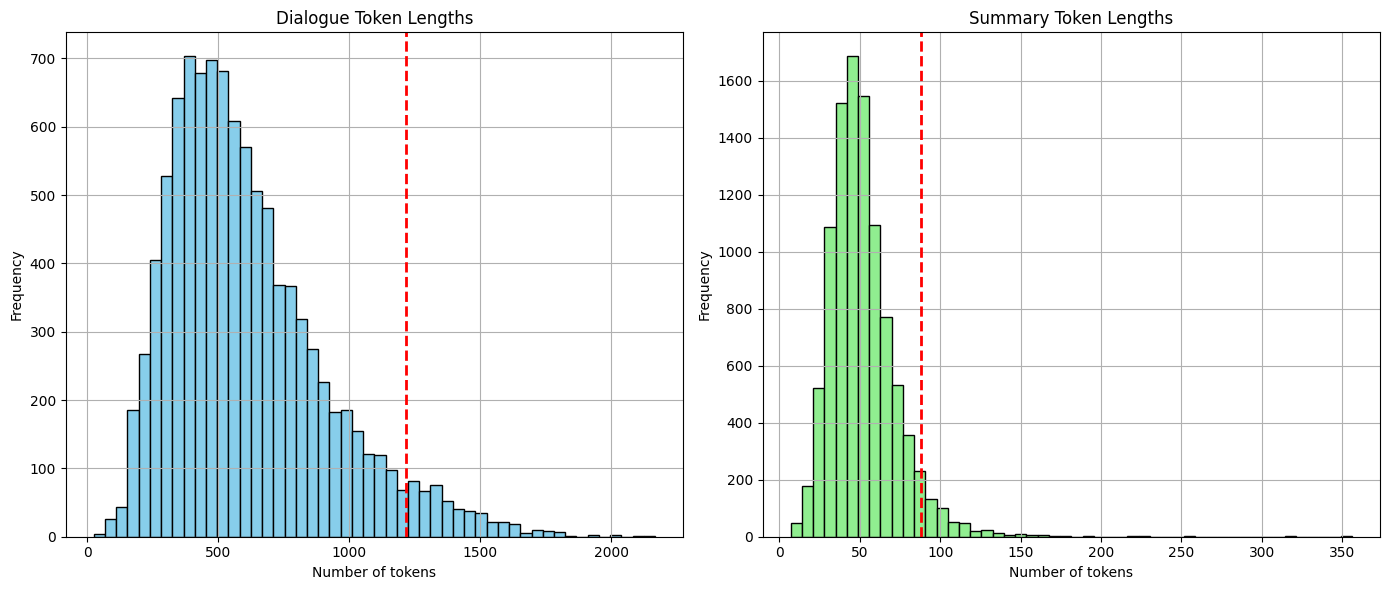

In [33]:
import matplotlib.pyplot as plt

article_lengths = train_data["article"].apply(lambda x: len(tokenizer.encode(x, truncation=False)))

highlights_lengths = train_data["highlights"].apply(lambda x: len(tokenizer.encode(x, truncation=False)))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(article_lengths, bins=50, color='skyblue', edgecolor='black')
plt.axvline(article_lengths.quantile(0.95), color='red', linestyle='dashed', linewidth=2)
plt.title("Dialogue Token Lengths")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(highlights_lengths, bins=50, color='lightgreen', edgecolor='black')
plt.axvline(highlights_lengths.quantile(0.95), color='red', linestyle='dashed', linewidth=2)
plt.title("Summary Token Lengths")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.grid(True)

plt.tight_layout()
plt.show()


In [34]:
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)


train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

# Tokenization

In [35]:
def tokenization(examples):
    model_inputs = tokenizer(
        examples["article"],
        max_length=int(max_input_len),
        truncation=True,
        padding="max_length"
    )
    
    labels = tokenizer(
        examples["highlights"],
        max_length=int(max_target_len),
        truncation=True,
        padding="max_length"
        )

    labels_ids = labels["input_ids"]


    new_labels = []
    for label_seq in labels_ids:
        new_labels.append([
            (label if label != tokenizer.pad_token_id else -100) for label in label_seq
        ])

    model_inputs["labels"] = new_labels

    return model_inputs


In [36]:
tokenized_train = train_dataset.map(tokenization, batched=True, batch_size=16, remove_columns=train_dataset.column_names)
tokenized_val = val_dataset.map(tokenization, batched=True, batch_size=16, remove_columns=val_dataset.column_names)


Map: 100%|██████████| 4000/4000 [00:10<00:00, 399.77 examples/s]


# Training Arguments & Trainer

In [37]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./t5-model_result",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=5,
    predict_with_generate=True,
    report_to="none",
    no_cuda=False,
    dataloader_num_workers=0,
    fp16=True
)

In [38]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
)


In [39]:
trainer.train()


  2%|▏         | 500/25000 [02:08<1:43:48,  3.93it/s]

{'loss': 3.1845, 'grad_norm': 8.065502166748047, 'learning_rate': 1.9603200000000002e-05, 'epoch': 0.1}


  4%|▍         | 1000/25000 [04:19<1:42:21,  3.91it/s]

{'loss': 2.9919, 'grad_norm': 5.51259708404541, 'learning_rate': 1.9204e-05, 'epoch': 0.2}


  6%|▌         | 1500/25000 [06:29<1:39:26,  3.94it/s]

{'loss': 2.9495, 'grad_norm': 5.914538383483887, 'learning_rate': 1.8804e-05, 'epoch': 0.3}


  8%|▊         | 2000/25000 [08:40<1:38:39,  3.89it/s]

{'loss': 2.9146, 'grad_norm': 6.069338798522949, 'learning_rate': 1.8404000000000002e-05, 'epoch': 0.4}


 10%|█         | 2500/25000 [10:50<1:35:23,  3.93it/s]

{'loss': 2.9074, 'grad_norm': 6.842526912689209, 'learning_rate': 1.8004000000000002e-05, 'epoch': 0.5}


 12%|█▏        | 3000/25000 [13:01<1:33:17,  3.93it/s]

{'loss': 2.9003, 'grad_norm': 6.916818618774414, 'learning_rate': 1.76048e-05, 'epoch': 0.6}


 14%|█▍        | 3500/25000 [15:12<1:31:58,  3.90it/s]

{'loss': 2.8599, 'grad_norm': 17.26193618774414, 'learning_rate': 1.7204800000000002e-05, 'epoch': 0.7}


 16%|█▌        | 4000/25000 [17:23<1:30:30,  3.87it/s]

{'loss': 2.872, 'grad_norm': 5.046464443206787, 'learning_rate': 1.6804800000000002e-05, 'epoch': 0.8}


 18%|█▊        | 4500/25000 [19:35<1:27:46,  3.89it/s]

{'loss': 2.8453, 'grad_norm': 6.535424709320068, 'learning_rate': 1.64048e-05, 'epoch': 0.9}


 20%|██        | 5000/25000 [21:45<1:24:22,  3.95it/s]

{'loss': 2.8618, 'grad_norm': 5.946524620056152, 'learning_rate': 1.60048e-05, 'epoch': 1.0}


                                                      
 20%|██        | 5000/25000 [24:40<1:24:22,  3.95it/s]

{'eval_loss': 2.530210018157959, 'eval_runtime': 172.5851, 'eval_samples_per_second': 23.177, 'eval_steps_per_second': 11.588, 'epoch': 1.0}


 22%|██▏       | 5500/25000 [26:48<1:23:20,  3.90it/s]  

{'loss': 2.8367, 'grad_norm': 7.400593280792236, 'learning_rate': 1.5605600000000002e-05, 'epoch': 1.1}


 24%|██▍       | 6000/25000 [28:59<1:21:17,  3.90it/s]

{'loss': 2.7627, 'grad_norm': 10.27779769897461, 'learning_rate': 1.52056e-05, 'epoch': 1.2}


 26%|██▌       | 6500/25000 [31:10<1:18:51,  3.91it/s]

{'loss': 2.7743, 'grad_norm': 8.865232467651367, 'learning_rate': 1.4805600000000003e-05, 'epoch': 1.3}


 28%|██▊       | 7000/25000 [33:21<1:17:08,  3.89it/s]

{'loss': 2.7654, 'grad_norm': 6.420201301574707, 'learning_rate': 1.4405600000000001e-05, 'epoch': 1.4}


 30%|███       | 7500/25000 [35:32<1:14:40,  3.91it/s]

{'loss': 2.7516, 'grad_norm': 8.083808898925781, 'learning_rate': 1.4006400000000002e-05, 'epoch': 1.5}


 32%|███▏      | 8000/25000 [37:43<1:12:30,  3.91it/s]

{'loss': 2.7867, 'grad_norm': 6.095561504364014, 'learning_rate': 1.3606400000000002e-05, 'epoch': 1.6}


 34%|███▍      | 8500/25000 [39:54<1:10:50,  3.88it/s]

{'loss': 2.811, 'grad_norm': 7.145437240600586, 'learning_rate': 1.3206400000000001e-05, 'epoch': 1.7}


 36%|███▌      | 9000/25000 [42:04<1:08:32,  3.89it/s]

{'loss': 2.7645, 'grad_norm': 7.350381374359131, 'learning_rate': 1.2806400000000002e-05, 'epoch': 1.8}


 38%|███▊      | 9500/25000 [44:15<1:06:16,  3.90it/s]

{'loss': 2.7655, 'grad_norm': 4.972773551940918, 'learning_rate': 1.24064e-05, 'epoch': 1.9}


 40%|████      | 10000/25000 [46:26<1:04:00,  3.91it/s]

{'loss': 2.7357, 'grad_norm': 6.38374137878418, 'learning_rate': 1.20064e-05, 'epoch': 2.0}


                                                       
 40%|████      | 10000/25000 [49:21<1:04:00,  3.91it/s]

{'eval_loss': 2.490318775177002, 'eval_runtime': 172.5852, 'eval_samples_per_second': 23.177, 'eval_steps_per_second': 11.588, 'epoch': 2.0}


 42%|████▏     | 10500/25000 [51:29<1:02:07,  3.89it/s]  

{'loss': 2.7366, 'grad_norm': 7.226229190826416, 'learning_rate': 1.16064e-05, 'epoch': 2.1}


 44%|████▍     | 11000/25000 [53:40<59:49,  3.90it/s]  

{'loss': 2.7427, 'grad_norm': 5.927580833435059, 'learning_rate': 1.1206400000000002e-05, 'epoch': 2.2}


 46%|████▌     | 11500/25000 [55:50<57:49,  3.89it/s]  

{'loss': 2.7585, 'grad_norm': 7.348710536956787, 'learning_rate': 1.0808e-05, 'epoch': 2.3}


 48%|████▊     | 12000/25000 [58:02<55:39,  3.89it/s]  

{'loss': 2.6805, 'grad_norm': 5.773550033569336, 'learning_rate': 1.0408000000000001e-05, 'epoch': 2.4}


 50%|█████     | 12500/25000 [1:00:14<53:52,  3.87it/s]

{'loss': 2.7461, 'grad_norm': 10.427749633789062, 'learning_rate': 1.0008e-05, 'epoch': 2.5}


 52%|█████▏    | 13000/25000 [1:02:25<51:45,  3.86it/s]  

{'loss': 2.6817, 'grad_norm': 4.772220134735107, 'learning_rate': 9.608e-06, 'epoch': 2.6}


 54%|█████▍    | 13500/25000 [1:04:37<49:29,  3.87it/s]  

{'loss': 2.7136, 'grad_norm': 5.435251712799072, 'learning_rate': 9.208e-06, 'epoch': 2.7}


 56%|█████▌    | 14000/25000 [1:06:48<47:17,  3.88it/s]  

{'loss': 2.7359, 'grad_norm': 4.768716335296631, 'learning_rate': 8.808000000000001e-06, 'epoch': 2.8}


 58%|█████▊    | 14500/25000 [1:09:00<45:19,  3.86it/s]  

{'loss': 2.7504, 'grad_norm': 3.4576632976531982, 'learning_rate': 8.408e-06, 'epoch': 2.9}


 60%|██████    | 15000/25000 [1:11:11<42:29,  3.92it/s]  

{'loss': 2.7091, 'grad_norm': 4.978166103363037, 'learning_rate': 8.008e-06, 'epoch': 3.0}


                                                       
 60%|██████    | 15000/25000 [1:14:07<42:29,  3.92it/s]

{'eval_loss': 2.4703919887542725, 'eval_runtime': 173.4607, 'eval_samples_per_second': 23.06, 'eval_steps_per_second': 11.53, 'epoch': 3.0}


 62%|██████▏   | 15500/25000 [1:16:16<40:45,  3.88it/s]    

{'loss': 2.7275, 'grad_norm': 12.305716514587402, 'learning_rate': 7.608000000000001e-06, 'epoch': 3.1}


 64%|██████▍   | 16000/25000 [1:18:28<38:38,  3.88it/s]  

{'loss': 2.7143, 'grad_norm': 5.351894855499268, 'learning_rate': 7.208e-06, 'epoch': 3.2}


 66%|██████▌   | 16500/25000 [1:20:39<36:20,  3.90it/s]  

{'loss': 2.7154, 'grad_norm': 13.790127754211426, 'learning_rate': 6.808e-06, 'epoch': 3.3}


 68%|██████▊   | 17000/25000 [1:22:49<34:09,  3.90it/s]  

{'loss': 2.6313, 'grad_norm': 8.557809829711914, 'learning_rate': 6.408000000000001e-06, 'epoch': 3.4}


 70%|███████   | 17500/25000 [1:25:00<32:04,  3.90it/s]  

{'loss': 2.6887, 'grad_norm': 5.921323776245117, 'learning_rate': 6.008000000000001e-06, 'epoch': 3.5}


 72%|███████▏  | 18000/25000 [1:27:11<30:03,  3.88it/s]  

{'loss': 2.6934, 'grad_norm': 5.961472511291504, 'learning_rate': 5.608800000000001e-06, 'epoch': 3.6}


 74%|███████▍  | 18500/25000 [1:29:23<28:01,  3.86it/s]  

{'loss': 2.7567, 'grad_norm': 5.623019218444824, 'learning_rate': 5.208800000000001e-06, 'epoch': 3.7}


 76%|███████▌  | 19000/25000 [1:31:34<25:54,  3.86it/s]  

{'loss': 2.6264, 'grad_norm': 4.812320709228516, 'learning_rate': 4.8088000000000004e-06, 'epoch': 3.8}


 78%|███████▊  | 19500/25000 [1:34:01<26:05,  3.51it/s]  

{'loss': 2.6959, 'grad_norm': 15.718547821044922, 'learning_rate': 4.4088e-06, 'epoch': 3.9}


 80%|████████  | 20000/25000 [1:36:27<27:07,  3.07it/s]  

{'loss': 2.6871, 'grad_norm': nan, 'learning_rate': 4.010400000000001e-06, 'epoch': 4.0}


                                                       
 80%|████████  | 20000/25000 [1:40:16<27:07,  3.07it/s]

{'eval_loss': 2.4678587913513184, 'eval_runtime': 226.9471, 'eval_samples_per_second': 17.625, 'eval_steps_per_second': 8.813, 'epoch': 4.0}


 82%|████████▏ | 20500/25000 [1:43:12<25:46,  2.91it/s]   

{'loss': 2.7039, 'grad_norm': 4.981429576873779, 'learning_rate': 3.6112000000000003e-06, 'epoch': 4.1}


 84%|████████▍ | 21000/25000 [1:46:10<20:54,  3.19it/s]  

{'loss': 2.6599, 'grad_norm': 8.326851844787598, 'learning_rate': 3.2112000000000003e-06, 'epoch': 4.2}


 86%|████████▌ | 21500/25000 [1:48:25<15:10,  3.84it/s]  

{'loss': 2.6526, 'grad_norm': 9.086710929870605, 'learning_rate': 2.8112e-06, 'epoch': 4.3}


 88%|████████▊ | 22000/25000 [1:50:37<12:56,  3.86it/s]

{'loss': 2.6792, 'grad_norm': 8.907578468322754, 'learning_rate': 2.4112000000000003e-06, 'epoch': 4.4}


 90%|█████████ | 22500/25000 [1:52:50<10:46,  3.87it/s]

{'loss': 2.6961, 'grad_norm': 5.887639999389648, 'learning_rate': 2.0112e-06, 'epoch': 4.5}


 92%|█████████▏| 23000/25000 [1:55:02<08:35,  3.88it/s]

{'loss': 2.6408, 'grad_norm': 6.527085304260254, 'learning_rate': 1.6112000000000003e-06, 'epoch': 4.6}


 94%|█████████▍| 23500/25000 [1:57:14<06:25,  3.89it/s]

{'loss': 2.6652, 'grad_norm': 5.163962364196777, 'learning_rate': 1.2112000000000002e-06, 'epoch': 4.7}


 96%|█████████▌| 24000/25000 [1:59:26<04:18,  3.86it/s]

{'loss': 2.666, 'grad_norm': 6.112136363983154, 'learning_rate': 8.112000000000001e-07, 'epoch': 4.8}


 98%|█████████▊| 24500/25000 [2:01:38<02:06,  3.94it/s]

{'loss': 2.6906, 'grad_norm': 5.145246505737305, 'learning_rate': 4.112e-07, 'epoch': 4.9}


100%|██████████| 25000/25000 [2:03:48<00:00,  3.93it/s]

{'loss': 2.6958, 'grad_norm': 6.484584808349609, 'learning_rate': 1.12e-08, 'epoch': 5.0}


                                                       
100%|██████████| 25000/25000 [2:06:43<00:00,  3.29it/s]

{'eval_loss': 2.464303731918335, 'eval_runtime': 172.2247, 'eval_samples_per_second': 23.225, 'eval_steps_per_second': 11.613, 'epoch': 5.0}
{'train_runtime': 7603.0338, 'train_samples_per_second': 6.576, 'train_steps_per_second': 3.288, 'train_loss': 2.7596649365234374, 'epoch': 5.0}


TrainOutput(global_step=25000, training_loss=2.7596649365234374, metrics={'train_runtime': 7603.0338, 'train_samples_per_second': 6.576, 'train_steps_per_second': 3.288, 'total_flos': 1.6058621952e+16, 'train_loss': 2.7596649365234374, 'epoch': 5.0})

# Visualize Evaluation

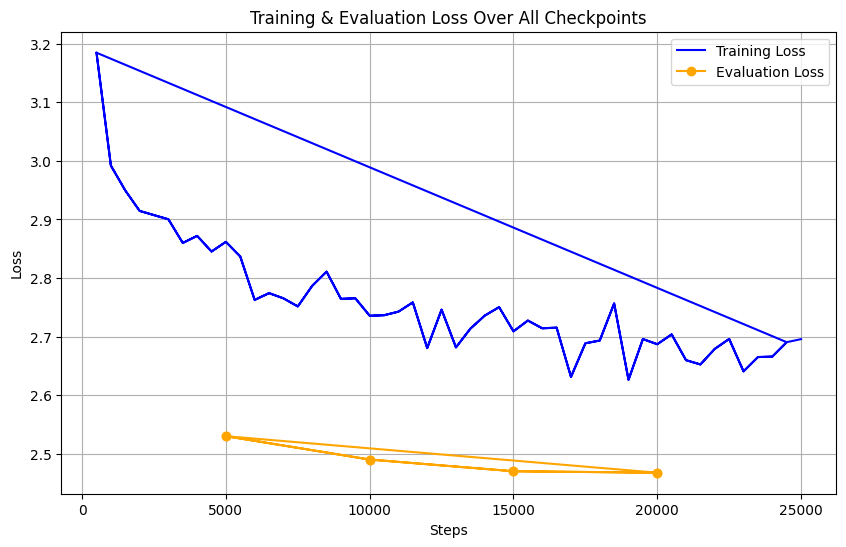

In [ ]:
import os
import json
import matplotlib.pyplot as plt


base_dir = r"t5-model_result"

steps, train_loss, eval_loss_steps, eval_loss_values = [], [], [], []


for folder in sorted(os.listdir(base_dir), key=lambda x: int(x.split("-")[-1]) if "-" in x else -1):
    folder_path = os.path.join(base_dir, folder)
    trainer_file = os.path.join(folder_path, "trainer_state.json")

    if os.path.isfile(trainer_file):
        with open(trainer_file, "r", encoding="utf-8") as f:
            data = json.load(f)

        for entry in data.get("log_history", []):
            if "loss" in entry:  
                steps.append(entry["step"])
                train_loss.append(entry["loss"])
            elif "eval_loss" in entry:  
                eval_loss_steps.append(entry["step"])
                eval_loss_values.append(entry["eval_loss"])

plt.figure(figsize=(10, 6))
plt.plot(steps, train_loss, label="Training Loss", color="blue")
plt.plot(eval_loss_steps, eval_loss_values, label="Evaluation Loss", color="orange", marker="o")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training & Evaluation Loss Over All Checkpoints")
plt.legend()
plt.grid(True)
plt.show()


# Save & Load Model

In [40]:
save_dir = "t5-Text-Summarizer"

model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)


('t5-Text-Summarizer\\tokenizer_config.json',
 't5-Text-Summarizer\\special_tokens_map.json',
 't5-Text-Summarizer\\spiece.model',
 't5-Text-Summarizer\\added_tokens.json')

In [ ]:
save_dir = "t5-Text-Summarizer"

model = T5ForConditionalGeneration.from_pretrained(save_dir)
tokenizer = T5Tokenizer.from_pretrained(save_dir)


# Show Predicted Summary 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def summarize_text(article):
    article = Preprocessing_text(article)  
    
    inputs = tokenizer(
        article,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    )

    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    outputs = model.generate(
        input_ids,
        attention_mask=attention_mask,  
        max_length=150,
        min_length=30,
        num_beams=4,
        length_penalty=2.0,
        early_stopping=True
    )

    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return summary


test_data["predicted_summary"] = test_data["article"].progress_apply(summarize_text)


100%|██████████| 2000/2000 [38:28<00:00,  1.15s/it]


In [119]:
print("The Article :\n",test_data["article"][0])

print(f"The Highlights:\n",test_data["highlights"][0])

print(f"The Predicted Summary:\n",test_data["predicted_summary"][0])


The Article :
 Comedian Jenny Eclair travelled with her other half on a Painting In Venus break with Flavours . There comes a time in a woman’s life when beach holidays just don’t cut it any longer, when lying on golden sands (unless you’re buried up to your neck) serves only to remind you how much weight you forgot to lose again this year and how ill-fitting your swimming costume is. Being control freaks, most fifty-something females find ‘doing nothing’ a bit boring – after all, there are only so many hours one can spend on a Kindle, and woman cannot live by fiction alone. This is the time when the ‘alternative holiday experience’ tickles your holiday tastebuds and you find yourself looking at brochures for Nordic cruises. Excellent! Everyone looks fat pointing at a fjord while wearing an Aran jumper. But apart from choosing chilly destinations such as the Arctic or Scarborough, your other non-lolling-about option is the ‘activity holiday’, which can range from Pilates to kayaking, o

# Question & Answering Model 

In [ ]:
qa_pipeline = pipeline("question-answering", model="distilbert-base-cased-distilled-squad")

def answer_question(question, context):
    result = qa_pipeline(question=question, context=context)
    return result['answer']


print(f"The Article:\n{test_data['article'][0]}\n")
print(f"The Highlights:\n{test_data['highlights'][0]}\n")
print(f"The Predicted Summary:\n{test_data['predicted_summary'][0]}\n")


summary = test_data['predicted_summary'][0]
context = test_data["article"][0]
questions = [
    "Who is the comedian?",
    "Where did the comedian travel?",
    "What was the main topic of the article?",
    "What kind of holiday is described?",
    "Why did the woman stop liking beach holidays?"
]

print("Q&A on the Summary:")
for q in questions:
    ans = qa_pipeline(question=q, context=context)
    print(f"Q: {q}")
    print(f"A: {ans['answer']}\n")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


The Article:
Comedian Jenny Eclair travelled with her other half on a Painting In Venus break with Flavours . There comes a time in a woman’s life when beach holidays just don’t cut it any longer, when lying on golden sands (unless you’re buried up to your neck) serves only to remind you how much weight you forgot to lose again this year and how ill-fitting your swimming costume is. Being control freaks, most fifty-something females find ‘doing nothing’ a bit boring – after all, there are only so many hours one can spend on a Kindle, and woman cannot live by fiction alone. This is the time when the ‘alternative holiday experience’ tickles your holiday tastebuds and you find yourself looking at brochures for Nordic cruises. Excellent! Everyone looks fat pointing at a fjord while wearing an Aran jumper. But apart from choosing chilly destinations such as the Arctic or Scarborough, your other non-lolling-about option is the ‘activity holiday’, which can range from Pilates to kayaking, or 

# Evaluation (BERTScore , ROUGEScore)

In [ ]:
refs = test_data["highlights"].tolist()
preds = test_data["predicted_summary"].tolist()


P, R, F1 = score(cands=preds, refs=refs, lang="en", verbose=True) 

print(f"BERTScore Precision: {P.mean().item():.4f}")
print(f"BERTScore Recall:    {R.mean().item():.4f}")
print(f"BERTScore F1:        {F1.mean().item():.4f}")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 63/63 [01:44<00:00,  1.66s/it]


computing greedy matching.


100%|██████████| 32/32 [00:00<00:00, 36.80it/s]

done in 105.51 seconds, 18.95 sentences/sec
BERTScore Precision: 0.8176
BERTScore Recall:    0.8209
BERTScore F1:        0.8191


In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge1_list = []
rouge2_list = []
rougeL_list = []

for ref, pred in zip(test_data["highlights"], test_data["predicted_summary"]):
    scores = scorer.score(ref, pred)
    rouge1_list.append(scores['rouge1'].fmeasure)
    rouge2_list.append(scores['rouge2'].fmeasure)
    rougeL_list.append(scores['rougeL'].fmeasure)

print(f"Average ROUGE-1 F1: {sum(rouge1_list)/len(rouge1_list):.4f}")
print(f"Average ROUGE-2 F1: {sum(rouge2_list)/len(rouge2_list):.4f}")
print(f"Average ROUGE-L F1: {sum(rougeL_list)/len(rougeL_list):.4f}")
    

Average ROUGE-1 F1: 0.2685
Average ROUGE-2 F1: 0.0849
Average ROUGE-L F1: 0.1998
